Load data generated by `bounds_change.py` script

In [1]:
from scipy.fftpack import fft, fftfreq, fftshift, ifftshift
import numpy as np
import matplotlib.pyplot as plt

fname = 'bounds_change_data.npz'
dat = np.load(fname)
t = dat['t'] # in fs
chi_t = dat['chi_t']
Sig_back_trc = dat['Sig_back_trc']
Ref_back_trc = dat['Ref_back_trc']
Sig_trc = dat['Sig_trc']
Ref_trc = dat['Ref_trc']

Transform time-domain fields into frequency domain fields, extract transmission coefficient $\tilde T=A(\omega)+i\phi(\omega)$ into `spec_m` and `spec_a` arrays representing $A(\omega)$ and $\phi(\omega)$, respectively. Plot the results

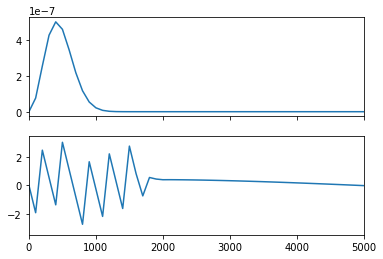

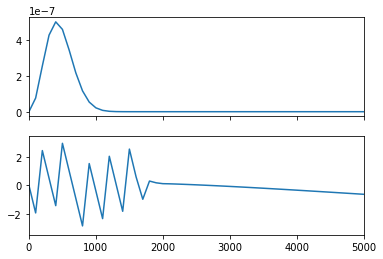

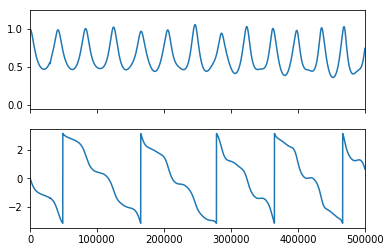

In [2]:
# Calculate time difference
dt = np.diff(t)[0] # Calculate time step difference in fs

# Calculate Fourier transforms
freq = fftfreq(len(t), dt) * 1e5 # in THz (since dt=0.01fs, 1/dt = 100/fs = 100*10^15/s = 100*10^3*10^12/s = 10^5*THz)
incf = fft(Ref_trc)
trans = fft(Sig_trc)

# Determine the number of data points and trim transforms to size
dpoints = len(freq)
freq = freq[0:int(dpoints/2)]
incf = incf[0:int(dpoints/2)]
trans = trans[0:int(dpoints/2)]

# Calculate spectrum in frequency
spec = np.divide(trans, incf)
spec_a = np.angle(spec)
spec_m = np.absolute(spec)

# Plot
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.plot(freq, np.absolute(incf))
ax1.plot(freq, np.angle(incf))
ax1.set_xlim(0, 5e3)
plt.show()

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.plot(freq, np.absolute(trans))
ax1.plot(freq, np.angle(trans))
ax1.set_xlim(0, 5e3)
plt.show()

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.plot(freq, spec_m)
ax1.plot(freq, spec_a)
ax1.set_xlim(0, 5e5)
plt.show()

We wish to calculate the index of refraction
$$\tilde{n}(\omega)=n(\omega)+i\kappa(\omega)$$
where $\kappa\ll n$. From Benjamin Ofori-Okai's 2016 PhD thesis p. 132 we note that in this case
$$n(\omega)=\frac{c_0}{\omega d}\phi(\omega)+1$$
where $\phi$ is the phase of the complex transmission $\tilde{T}$ and $d$ is the length of the material. Ben's thesis also notes that
$$\kappa(\omega)=-\frac{c_0}{\omega d}\ln{\left(A(\omega)\frac{\left(n(\omega)+1\right)^2}{4n(\omega)}\right)}$$
where $A(\omega)$ is the magnitude of the complex transmission $\tilde{T}$.

In [3]:
# Set constants (MAKE SURE THAT THESE ARE UP TO DATE WITH DATA TO LOAD IN)
c0 = 1 # Taken from original.py
L = 0.09 # Material length

# Calculate omega
omega = 2 * np.pi * freq

# Calculate coefficients
coeff = np.divide(c0, np.multiply(omega, L))

# Calculate the real part of the index of refraction
n = np.multiply(coeff, spec_a) + 1

# Calculate the imaginary part of the index of refraction
kappa = np.multiply(-coeff, np.log(np.multiply(spec_m, np.divide(np.square(n+1), 4*n))))

/Users/jroth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/jroth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


We finally plot these results

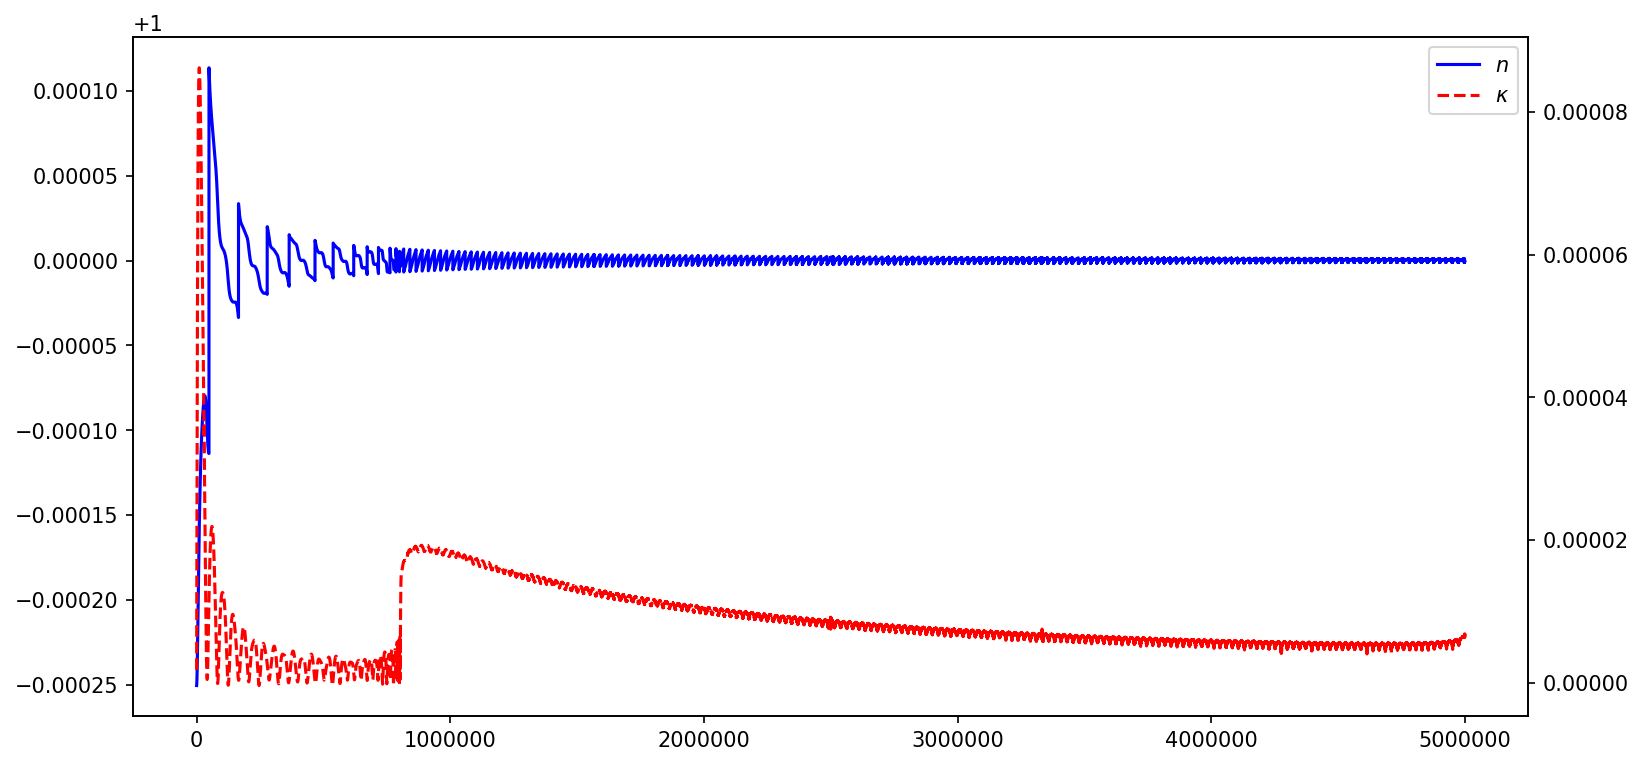

In [4]:
# Setup plot
fig = plt.figure(figsize=(12, 6), dpi=200)
fig.set_dpi(150)
ax0 = plt.gca()
ax1 = ax0.twinx()

# Plot n
n_line, = ax0.plot(freq, n, 'b-')

# Plot kappa
kappa_line, = ax1.plot(freq, kappa, 'r--')

# Post formatting and display
ax0.legend((n_line, kappa_line), ('$n$', '$\kappa$'), loc=1)
plt.show()

We next use a Laplace transform to convert $\chi(t)$ to $\chi(\omega)$. Recall that
$$\chi(t)=e^{-\gamma t}\left[A_1e^{\beta t}+A_2e^{-\beta t}\right]$$
In the simulation we selected
$$
A_1=-A_2 \\
$$
As such $\chi(t)$ reduces to

$$
\chi(t)=A_1e^{-\gamma t}\left[e^{\beta t}-e^{-\beta t}\right]
$$

$$
\gamma = 2\pi\times0.01 \\
\omega = 2\pi\times1 \\
\beta=\sqrt{\gamma^2-\omega^2}=2\pi\sqrt{0.01^2-1^2}=i2\pi\sqrt{0.9999}\approx i2\pi \\
A_1=\frac{1}{2\beta}\approx-\frac{i}{4\pi} \\
$$

In [ ]:
eps_mat = 16;                                       # high frequency dielectric constant of material

L = 0.09;                                           # (um) thickness of sample
nu_j = 1;                                           # (THz) resonant frequency of oscillator
gamma = 0.01;                                       # (THz) linewidth
gamma_j = gamma * 2 * np.pi;

beta_j = np.sqrt((gamma_j)**2 - (2*np.pi*nu_j)**2, dtype=np.complex64);      # (THz) effective oscillation frequency
A = 1

A_1j = A*1/(2*beta_j);                           # Oscillator amplitude
A_2j = A*-1/(2*beta_j);                          # Oscillator amplitude                                  # (a.u.) oscillator amplitude


Continue working on taking the Fourier transform of Chi in time to get Chi in frequency. Then use this to determine the refractive index via
$$
n=\frac{c}{v}=\sqrt{\frac{\mu_0\epsilon_0}{\mu\epsilon}}
$$
in our case $\mu=\mu_0$ and $\epsilon=\epsilon_0(1+\chi)$ (as this is a linear dielectric), so
$$
n=\frac{1}{1+\chi}
$$
Since $\chi$ is a function of frequency $\omega$ we find
$$
n(\omega)=\frac{1}{1+\chi(\omega)}
$$